# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import random
from sklearn.model_selection import KFold
%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [2]:
train = pd.read_csv("Higgs_train.csv")
train.columns = train.columns.map(lambda x: x.replace(' ', '_'))
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
train.head()

,lepton_pT,_lepton_eta,_lepton_phi,_missing_energy_magnitude,_missing_energy_phi,_jet_1_pt,_jet_1_eta,_jet_1_phi,_jet_1_b-tag,_jet_2_pt,...,_jet_4_phi,_jet_4_b-tag,_m_jj,_m_jjj,_m_lv,_m_jlv,_m_bb,_m_wbb,_m_wwbb,_class
0,0.376816,-1.583727,-1.707552,0.990897,0.114397,1.253553,0.619859,-1.479572,2.173076,0.753658,...,0.397156,0.000000,0.522449,1.318622,0.982398,1.359610,0.964809,1.309991,1.083203,1.0
1,0.707330,0.087603,-0.399742,0.918742,-1.229936,1.172847,-0.552574,0.886053,2.173076,1.298317,...,0.236231,0.000000,0.439696,0.828885,0.992241,1.157820,2.215780,1.189586,0.937976,1.0
2,0.617290,0.265839,-1.345227,1.154581,1.036646,0.954822,0.377252,-0.147960,0.000000,1.063507,...,-0.542413,0.000000,1.024506,1.026255,0.986289,0.927720,1.371080,0.981672,0.917436,1.0
3,0.850992,-0.380876,-0.071264,1.468704,-0.795133,0.691818,0.883260,0.496881,0.000000,1.616349,...,-1.520171,0.000000,1.197755,1.100534,0.987262,1.353453,1.455383,0.994682,0.953553,1.0
4,0.767540,-0.691572,-0.040191,0.614843,0.143765,0.748614,0.397057,-0.873640,0.000000,1.147862,...,0.502034,1.550981,0.921948,0.864080,0.982839,1.373222,0.601492,0.918621,0.957063,0.0


In [3]:
test = pd.read_csv("Higgs_test.csv")
test.columns = test.columns.map(lambda x: x.replace(' ', '_'))
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
test.head()

,lepton_pT,_lepton_eta,_lepton_phi,_missing_energy_magnitude,_missing_energy_phi,_jet_1_pt,_jet_1_eta,_jet_1_phi,_jet_1_b-tag,_jet_2_pt,...,_jet_4_phi,_jet_4_b-tag,_m_jj,_m_jjj,_m_lv,_m_jlv,_m_bb,_m_wbb,_m_wwbb,_class
0,0.883751,-0.461715,0.196283,1.330217,1.522737,1.039467,-1.519038,-1.457952,2.173076,0.361469,...,-1.137282,0.000000,1.454688,0.790714,1.397708,1.250985,0.712875,0.811940,0.820693,1.0
1,0.780168,-0.292245,0.897072,0.384474,0.412700,1.215078,-0.466424,-0.920208,0.000000,1.104803,...,-0.091825,0.000000,0.812113,0.727805,0.975326,0.636811,0.569234,0.776607,0.715494,1.0
2,0.352659,-1.073368,-1.741953,1.174700,-0.198694,0.557980,0.057408,-1.491768,1.086538,0.911667,...,1.545824,0.000000,0.829461,1.060325,0.992326,0.824898,0.365448,0.800015,0.765989,0.0
3,0.757292,0.821975,-1.290851,0.207558,-0.150971,1.222224,-1.638856,1.531346,0.000000,1.683582,...,0.116925,3.101961,4.290139,2.415188,0.994889,0.923447,0.927035,1.755831,1.362970,1.0
4,2.038721,2.025801,-0.471873,0.423674,-1.497848,1.062186,0.798100,1.218678,2.173076,0.805279,...,-0.079062,3.101961,0.894990,0.936199,1.027161,1.559567,1.148236,1.115536,1.157044,1.0


In [4]:
depths = [i for i in range(2, 11)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))
print("For depth of 2, 3, ..., 10:")
print("train scores are: \n", train_scores)
print("test scores are: \n", test_scores)

For depth of 2, 3, ..., 10:
train scores are: 
 [0.63859999999999995, 0.64219999999999999, 0.66020000000000001, 0.68200000000000005, 0.71060000000000001, 0.74280000000000002, 0.7752, 0.81579999999999997, 0.84660000000000002]
test scores are: 
 [0.64300000000000002, 0.64319999999999999, 0.64959999999999996, 0.64559999999999995, 0.65659999999999996, 0.64739999999999998, 0.62619999999999998, 0.62180000000000002, 0.62839999999999996]


In [5]:
total_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)  
    # Perform 5-fold cross validation 
    score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    total_scores.append((depth, np.mean(score)))
total_scores

[(2, 0.62320749580749579),
 (3, 0.62041149381149385),
 (4, 0.63580570720570717),
 (5, 0.64021150901150903),
 (6, 0.62760550420550421),
 (7, 0.62920630460630456),
 (8, 0.62480109780109783),
 (9, 0.62600730120730119),
 (10, 0.61720309740309742)]

In [6]:
# max(total_scores, key=lambda x:x[1])
best_depth = max(total_scores, key=lambda x:x[1])[0]
print("The depth of the tree using 5-fold cross-validation is:", best_depth)

The depth of the tree using 5-fold cross-validation is: 5


In [7]:
clf = DecisionTreeClassifier(max_depth = best_depth)
clf.fit(X_train,y_train)
print("classification accuracy on the test set is:", clf.score(X_test, y_test))

classification accuracy on the test set is: 0.6456


## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets.
- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

#### Question 2.1: Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.

In [8]:
tree_numbers = [2**i for i in range(1, 9)]
true_train = y_train.tolist()
true_test = y_test.tolist()
N = len(true_train)

In [9]:
accuracy_train = []
accuracy_test = []
for B in tree_numbers:
    
    trees = []
    for _ in range(B):
        X_train_new = X_train.copy()
        for c in list(X_train):
            rand_number = random.random()  
            if rand_number < 0.5:
                X_train_new[c] = 0
        dt = DecisionTreeClassifier(max_depth = 5, max_features=None, random_state=109)
        trees.append(dt.fit(X_train_new, y_train))

    tree_preds_train = []
    tree_preds_test = []
    for tree in trees:
        tree_preds_train.append(tree.predict(X_train))
        tree_preds_test.append(tree.predict(X_test))

    predicted_train = pd.DataFrame(np.array(tree_preds_train)).T.mode(axis=1)[0].tolist()
    predicted_test = pd.DataFrame(np.array(tree_preds_test)).T.mode(axis=1)[0].tolist()
    
    diff_train = [a - b for a, b in zip(true_train, predicted_train)]
    diff_test = [a - b for a, b in zip(true_test, predicted_test)]
    
    correct_train = sum(1 for x in diff_train if x == 0)
    correct_test = sum(1 for x in diff_test if x == 0)
    
    accuracy_train.append(correct_train / N)
    accuracy_test.append(correct_test / N)

In [10]:
print("train accuracy for different number of trees 2, 4, 8, 16, ..., 256\n", accuracy_train)
 
print("test accuracy for different number of trees 2, 4, 8, 16, ..., 256\n", accuracy_test)

train accuracy for different number of trees 2, 4, 8, 16, ..., 256
 [0.663, 0.679, 0.7318, 0.6912, 0.729, 0.719, 0.7318, 0.734]
test accuracy for different number of trees 2, 4, 8, 16, ..., 256
 [0.6264, 0.629, 0.673, 0.6368, 0.679, 0.6818, 0.6862, 0.6884]


#### Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.

- Yes. We can see that as the number of trees increases, the accuracy for both training and test data set increases.
- Increase in the number of trees leads to the increase in varinace, and the bias goes down because the probability to get the correct prediction increases.

#### Question 2.2: Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.

In [11]:
rates = [0.1, 0.3, 0.5, 0.7, 0.9]

accuracy_train_p = []
accuracy_test_p = []

for p in rates:
    
    trees = []
    for _ in range(64):
        X_train_new = X_train.copy()
        for c in list(X_train):
            rand_number = random.random()  
            if rand_number < p:
                X_train_new[c] = 0
        dt = DecisionTreeClassifier(max_depth = 5, max_features=None, random_state=109)
        trees.append(dt.fit(X_train_new, y_train))

    tree_preds_train = []
    tree_preds_test = []
    for tree in trees:
        tree_preds_train.append(tree.predict(X_train))
        tree_preds_test.append(tree.predict(X_test))

    predicted_train = pd.DataFrame(np.array(tree_preds_train)).T.mode(axis=1)[0].tolist()
    predicted_test = pd.DataFrame(np.array(tree_preds_test)).T.mode(axis=1)[0].tolist()
    
    diff_train = [a - b for a, b in zip(true_train, predicted_train)]
    diff_test = [a - b for a, b in zip(true_test, predicted_test)]
    
    correct_train = sum(1 for x in diff_train if x == 0)
    correct_test = sum(1 for x in diff_test if x == 0)
    
    accuracy_train_p.append(correct_train / N)
    accuracy_test_p.append(correct_test / N)

In [12]:
print("train accuracy with dropout rates 0.1, 0.3, 0.5, 0.7, 0.9: \n", accuracy_train_p)
print("test accuracy with dropout rates 0.1, 0.3, 0.5, 0.7, 0.9: \n", accuracy_test_p)

train accuracy with dropout rates 0.1, 0.3, 0.5, 0.7, 0.9: 
 [0.6818, 0.7068, 0.7348, 0.73, 0.5916]
test accuracy with dropout rates 0.1, 0.3, 0.5, 0.7, 0.9: 
 [0.6456, 0.6652, 0.686, 0.6658, 0.5588]


#### Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.

- Simply looking at the trend, we can see that at first, as the dropout rate increases, the accuracy goes up; but as the dropout rate keeps increasing, the accuracy decreases.
- Therefore, at the first stage when we increase the dropout rate, the variance of the model decreases and the bias decreases. At the second stage, as the dropout rate keeps increasing, every model will be more similar to each other and hence the variance keeps decreasing to a very low value, and the bias goes up.

#### Question 2.3: Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?

In [35]:
combination = {}
combination[(2,0.1)], combination[(2,0.3)], combination[(2,0.5)],  combination[(2,0.7)], combination[(2,0.9)], \
combination[(4,0.1)], combination[(4,0.3)], combination[(4,0.5)],  combination[(4,0.7)], combination[(4,0.9)], \
combination[(8,0.1)], combination[(8,0.3)], combination[(8,0.5)],  combination[(8,0.7)], combination[(8,0.9)], \
combination[(16,0.1)], combination[(16,0.3)], combination[(16,0.5)],  combination[(16,0.7)], combination[(16,0.9)], \
combination[(32,0.1)], combination[(32,0.3)], combination[(32,0.5)],  combination[(32,0.7)], combination[(32,0.9)], \
combination[(64,0.1)], combination[(64,0.3)], combination[(64,0.5)],  combination[(64,0.7)], combination[(64,0.9)], \
combination[(128,0.1)], combination[(128,0.3)], combination[(128,0.5)],  combination[(128,0.7)], combination[(128,0.9)], \
combination[(256,0.1)], combination[(256,0.3)], combination[(256,0.5)],  combination[(256,0.7)], combination[(256,0.9)], \
= ([] for i in range(40))


In [36]:
for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    true_train_cv = y_train_cv.tolist()
    true_valid_cv = y_valid_cv.tolist()


    for B in tree_numbers:
#         print("number of tree", B)
        for p in rates:
#             print("rate", p)
            trees = []
            for _ in range(B):
                X_train_new = X_train_cv.copy()
                for c in list(X_train_cv):
                    rand_number = random.random()  
                    if rand_number < p:
                        X_train_new[c] = 0
                dt = DecisionTreeClassifier(max_depth = 5, max_features=None, random_state=109)
                trees.append(dt.fit(X_train_new, y_train_cv))
#             tree_preds_train = []
            tree_preds_valid = []
            for tree in trees:
#                 tree_preds_train.append(tree.predict(X_train_cv))
                tree_preds_valid.append(tree.predict(X_valid_cv))

#             predicted_train = pd.DataFrame(np.array(tree_preds_train)).T.mode(axis=1)[0].tolist()
            predicted_valid = pd.DataFrame(np.array(tree_preds_valid)).T.mode(axis=1)[0].tolist()

#             diff_train = [a - b for a, b in zip(true_train_cv, predicted_train)]
            diff_valid = [a - b for a, b in zip(true_valid_cv, predicted_valid)]

#             correct_train = sum(1 for x in diff_train if x == 0) / len(X_valid_cv)
            correct_valid = sum(1 for x in diff_valid if x == 0) / len(X_valid_cv)
#             print(correct_valid)
            
            combination[(B,p)].append(correct_valid)

In [37]:
# combination

{(2, 0.1): [0.646, 0.638, 0.629, 0.654, 0.619],
 (2, 0.3): [0.662, 0.644, 0.54, 0.638, 0.596],
 (2, 0.5): [0.576, 0.639, 0.626, 0.612, 0.642],
 (2, 0.7): [0.654, 0.622, 0.615, 0.617, 0.624],
 (2, 0.9): [0.587, 0.55, 0.502, 0.544, 0.521],
 (4, 0.1): [0.652, 0.644, 0.633, 0.631, 0.624],
 (4, 0.3): [0.662, 0.642, 0.663, 0.632, 0.626],
 (4, 0.5): [0.665, 0.595, 0.633, 0.658, 0.615],
 (4, 0.7): [0.642, 0.661, 0.6, 0.631, 0.615],
 (4, 0.9): [0.637, 0.579, 0.649, 0.523, 0.572],
 (8, 0.1): [0.647, 0.645, 0.643, 0.633, 0.622],
 (8, 0.3): [0.665, 0.654, 0.645, 0.643, 0.646],
 (8, 0.5): [0.663, 0.664, 0.62, 0.669, 0.655],
 (8, 0.7): [0.661, 0.645, 0.657, 0.645, 0.605],
 (8, 0.9): [0.546, 0.563, 0.566, 0.589, 0.595],
 (16, 0.1): [0.645, 0.644, 0.63, 0.63, 0.619],
 (16, 0.3): [0.683, 0.643, 0.654, 0.669, 0.662],
 (16, 0.5): [0.663, 0.663, 0.644, 0.667, 0.652],
 (16, 0.7): [0.652, 0.633, 0.651, 0.663, 0.608],
 (16, 0.9): [0.569, 0.566, 0.525, 0.596, 0.616],
 (32, 0.1): [0.647, 0.643, 0.631, 0.63, 0.

In [38]:
for key, value in combination.items():
    combination[key] = sum(value) / len(value)
best_combi = max(combination, key=combination.get)
# best_combi

(64, 0.5)

In [39]:
print("best combination is:", best_combi)

best combination is: (64, 0.5)


In [44]:
trees = []
for _ in range(64):
    X_train_new = X_train.copy()
    for c in list(X_train):
        rand_number = random.random()  
        if rand_number < 0.5:
            X_train_new[c] = 0
    dt = DecisionTreeClassifier(max_depth = 5, max_features=None, random_state=109)
    trees.append(dt.fit(X_train_new, y_train))

tree_preds_train = []
tree_preds_test = []
for tree in trees:
    tree_preds_train.append(tree.predict(X_train))
    tree_preds_test.append(tree.predict(X_test))

predicted_train = pd.DataFrame(np.array(tree_preds_train)).T.mode(axis=1)[0].tolist()
predicted_test = pd.DataFrame(np.array(tree_preds_test)).T.mode(axis=1)[0].tolist()
    
diff_train = [a - b for a, b in zip(true_train, predicted_train)]
diff_test = [a - b for a, b in zip(true_test, predicted_test)]
    
correct_train = sum(1 for x in diff_train if x == 0)
correct_test = sum(1 for x in diff_test if x == 0)
    
accuracy_train_best = correct_train / N
accuracy_test_best = correct_test / N

In [46]:
print("an ensemble of trees fitted with the optimal dropout rate 0.5 and number of trees 64:")
print("training accuracy:", accuracy_train_best)
print("test accuracy:", accuracy_test_best)

an ensemble of trees fitted with the optimal dropout rate 0.5 and number of trees 64:
training accuracy: 0.7386
test accuracy: 0.686


#### How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?¶

- The single decision tree model in Question 1 gives accuracy 0.6456 on the test set, whereas this ensemble of trees gives accuracy 0.686 on the test set, which is better than the former method.

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





#### Quesrion 3.1: How does a random forest approach differ from the dropout procedure described in Question 2?

- Random forest first bootstraps samples from the entire training set, but the dropout procedure uses full dataset.
- Random forest randomly picks a certain number of predictors ($\sqrt{p}$ in this problem), whereas the dropout procedure has a tunable probability to select each predictor.

#### Quesrion 3.2: Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

In [47]:
rf_train_scores = []
rf_test_scores = []
for t in tree_numbers:
    print("Number of trees:", t)
    rf = RandomForestClassifier(n_estimators=t, max_depth=5, max_features="sqrt", random_state=109) # unrestricted depth because of random forest
    rf.fit(X_train, y_train)
    rf_train_scores.append(rf.score(X_train, y_train))
    print("Train score:", rf.score(X_train, y_train))
    rf_test_scores.append(rf.score(X_test, y_test))
    print("Test score:", rf.score(X_test, y_test))

Number of trees: 2
Train score: 0.668
Test score: 0.6284
Number of trees: 4
Train score: 0.6892
Test score: 0.6576
Number of trees: 8
Train score: 0.7148
Test score: 0.6604
Number of trees: 16
Train score: 0.7156
Test score: 0.6676
Number of trees: 32
Train score: 0.7228
Test score: 0.6848
Number of trees: 64
Train score: 0.729
Test score: 0.6878
Number of trees: 128
Train score: 0.7362
Test score: 0.6874
Number of trees: 256
Train score: 0.741
Test score: 0.691


#### Question 3.3: Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier.

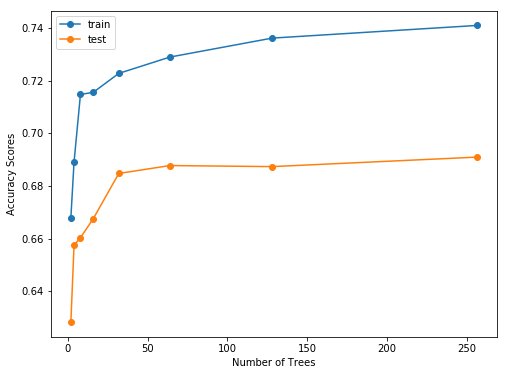

In [48]:
plt.figure(figsize=(8, 6))
# x = [1,2,3,4,5,6,7,8]
plt.plot(tree_numbers, rf_train_scores, marker='o', label="train")
plt.plot(tree_numbers, rf_test_scores, marker='o', label="test")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy Scores")
# plt.xticks(x, tree_numbers)
plt.legend()
plt.show()

- A larger number of trees improves the test accuracy. The improvement is rapid at first, but slows down when the number of trees is already large enough.
- As the number of trees increases, both of the training accuracy and test accuracy goes up. The increase is initially very fast; however, the increase slows down later and tends to stay at the same level.
- Bias-variance trade-off: Random forest can only decrease variance, not bias, and we know that error = variance + bias. This is because the error of the entire forest is roughly equal to the bias of a single tree, and to lower the bias, we need to let the tree grow very deep. In random forests, we usually allow the depth of the individual trees to be unrestricted. But in this problem, we restrict the max depth to be 5, so the bias is not low initially. As we increase the number of trees, the variance is decreasing. But at some point, there is no need to add more trees because it cannot decrease variance anymore. So the accuracy score will converge.

#### Question 3.4: Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2? 

In [49]:
# choose optimum as smallest number of trees "sufficiently" close to maximum train accuracy
for i in range(len(rf_test_scores)):
    if np.max(rf_test_scores)-rf_test_scores[i]<0.01:
        n_trees_optimal=i+1
        break

print("reasonable number of trees:", 2**n_trees_optimal)

reasonable number of trees: 32


In [50]:
accuracy_train_cv = np.zeros((29,5))
accuracy_valid_cv = np.zeros((29,5))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    for i in range(1,29):
#         print("max_feature =", i)
        rf = RandomForestClassifier(n_estimators=32, max_depth = 5, max_features=i, random_state=109)
        rf.fit(X_train_cv, y_train_cv)
        
        accuracy_train_cv[i,fold_ctr] = rf.score(X_train_cv, y_train_cv)
        accuracy_valid_cv[i,fold_ctr] = rf.score(X_valid_cv, y_valid_cv)
        
    fold_ctr += 1

In [51]:
# accuracy_train_cv[1:], accuracy_valid_cv[1:]

In [52]:
scores_train = np.mean(accuracy_train_cv, axis=1)[1:]      
scores_valid = np.mean(accuracy_valid_cv, axis=1)[1:]

In [53]:
# choose optimum as smallest number of components "sufficiently" close to maximum validation accuracy
for i in range(len(scores_valid)):
    if np.max(scores_valid)-scores_valid[i]<0.002:
        n_predictors_optimal=i+1
        break

print("maximum validation accuracy using %i predictors" % n_predictors_optimal)

maximum validation accuracy using 7 predictors


In [54]:
rf = RandomForestClassifier(n_estimators=32, max_depth = 5, max_features=n_predictors_optimal)
rf.fit(X_train, y_train)
print("Test accuracy with 32 trees and 7 features:", rf.score(X_test, y_test))

Test accuracy with 32 trees and 7 features: 0.6892


#### How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?

- The test performance of random forest model with the optimal number of trees on the test set is 0.6892, whereas the perfomance of the dropout approach on the test set is 0.686. So the random forest model is a little better than the dropout approach.

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



#### Question 4.1: Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).

In [55]:
s1_train = []
s1_test = []
for b in [1, 2, 10, None]:
#     print("Tree depths for the base learners:", b)
    s2_train = []
    s2_test = []
    for n in tree_numbers:
#         print("Number of trees:", n)
        adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=b), n_estimators=n, learning_rate=0.05)
        adaboost.fit(X_train, y_train)
        s2_train.append(adaboost.score(X_train, y_train))
        s2_test.append(adaboost.score(X_test, y_test))
#         print("Train score:", adaboost.score(X_train, y_train))
#         print("Test score:", adaboost.score(X_test, y_test))
    s1_train.append(s2_train)
    s1_test.append(s2_test)   

In [56]:
# s1_train

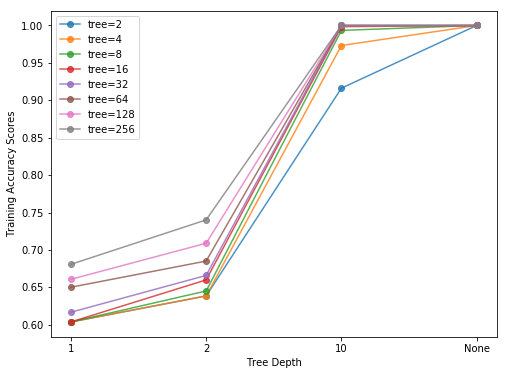

In [57]:
# as a function of tree depth (train set):
n_trees_2_train = [item[0] for item in s1_train]
n_trees_4_train = [item[1] for item in s1_train]
n_trees_8_train = [item[2] for item in s1_train]
n_trees_16_train = [item[3] for item in s1_train]
n_trees_32_train = [item[4] for item in s1_train]
n_trees_64_train = [item[5] for item in s1_train]
n_trees_128_train = [item[6] for item in s1_train]
n_trees_256_train = [item[7] for item in s1_train]

plt.figure(figsize=(8, 6))
labels = ['1', '2', '10', 'None']
x = [1,2,3,4]
plt.plot(x, n_trees_2_train, marker='o', label="tree=2", alpha=0.8)
plt.plot(x, n_trees_4_train, marker='o', label="tree=4", alpha=0.8)
plt.plot(x, n_trees_8_train, marker='o', label="tree=8", alpha=0.8)
plt.plot(x, n_trees_16_train, marker='o', label="tree=16", alpha=0.8)
plt.plot(x, n_trees_32_train, marker='o', label="tree=32", alpha=0.8)
plt.plot(x, n_trees_64_train, marker='o', label="tree=64", alpha=0.8)
plt.plot(x, n_trees_128_train, marker='o', label="tree=128", alpha=0.8)
plt.plot(x, n_trees_256_train, marker='o', label="tree=256", alpha=0.8)
plt.xticks(x, labels)
plt.xlabel("Tree Depth")
plt.ylabel("Training Accuracy Scores")
plt.legend()
plt.show()

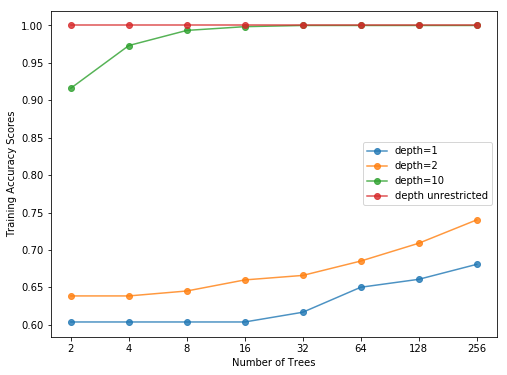

In [58]:
# as a function of number of trees:
plt.figure(figsize=(8, 6))
labels = ['2', '4', '8', '16', '32', '64', '128', '256']
x = [1,2,3,4,5,6,7,8]
plt.plot(x, s1_train[0], marker='o', label="depth=1", alpha=0.8)
plt.plot(x, s1_train[1], marker='o', label="depth=2", alpha=0.8)
plt.plot(x, s1_train[2], marker='o', label="depth=10", alpha=0.8)
plt.plot(x, s1_train[3], marker='o', label="depth unrestricted", alpha=0.8)

plt.xticks(x, labels)
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy Scores")
plt.legend()
plt.show()

#### Question 4.2: How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

labels = ['2', '4', '8', '16', '32', '64', '128', '256']
x = [1,2,3,4,5,6,7,8]
ax1.plot(x, s1_train[0], marker='o', label="depth=1", alpha=0.8)
ax1.plot(x, s1_train[1], marker='o', label="depth=2", alpha=0.8)
ax1.plot(x, s1_train[2], marker='o', label="depth=10", alpha=0.8)
ax1.plot(x, s1_train[3], marker='o', label="depth unrestricted", alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel("Number of Trees")
ax1.set_ylabel("Train Accuracy Scores")
ax1.legend()


ax2.plot(x, s1_test[0], marker='o', label="depth=1", alpha=0.8)
ax2.plot(x, s1_test[1], marker='o', label="depth=2", alpha=0.8)
ax2.plot(x, s1_test[2], marker='o', label="depth=10", alpha=0.8)
ax2.plot(x, s1_test[3], marker='o', label="depth unrestricted", alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel("Number of Trees")
ax2.set_ylabel("Test Accuracy Scores")
ax2.legend()
plt.show()

#### Question 4.3: How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.

In [ ]:
# as a function of tree depth (test set):
n_trees_2_test = [item[0] for item in s1_test]
n_trees_4_test = [item[1] for item in s1_test]
n_trees_8_test = [item[2] for item in s1_test]
n_trees_16_test = [item[3] for item in s1_test]
n_trees_32_test = [item[4] for item in s1_test]
n_trees_64_test = [item[5] for item in s1_test]
n_trees_128_test = [item[6] for item in s1_test]
n_trees_256_test = [item[7] for item in s1_test]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
labels = ['1', '2', '10', 'None']
x = [1,2,3,4]

ax1.plot(x, n_trees_2_train, marker='o', label="tree=2", alpha=0.8)
ax1.plot(x, n_trees_4_train, marker='o', label="tree=4", alpha=0.8)
ax1.plot(x, n_trees_8_train, marker='o', label="tree=8", alpha=0.8)
ax1.plot(x, n_trees_16_train, marker='o', label="tree=16", alpha=0.8)
ax1.plot(x, n_trees_32_train, marker='o', label="tree=32", alpha=0.8)
ax1.plot(x, n_trees_64_train, marker='o', label="tree=64", alpha=0.8)
ax1.plot(x, n_trees_128_train, marker='o', label="tree=128", alpha=0.8)
ax1.plot(x, n_trees_256_train, marker='o', label="tree=256", alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel("Tree Depth")
ax1.set_ylabel("Train Accuracy Scores")
ax1.legend()

ax2.plot(x, n_trees_2_test, marker='o', label="tree=2", alpha=0.8)
ax2.plot(x, n_trees_4_test, marker='o', label="tree=4", alpha=0.8)
ax2.plot(x, n_trees_8_test, marker='o', label="tree=8", alpha=0.8)
ax2.plot(x, n_trees_16_test, marker='o', label="tree=16", alpha=0.8)
ax2.plot(x, n_trees_32_test, marker='o', label="tree=32", alpha=0.8)
ax2.plot(x, n_trees_64_test, marker='o', label="tree=64", alpha=0.8)
ax2.plot(x, n_trees_128_test, marker='o', label="tree=128", alpha=0.8)
ax2.plot(x, n_trees_256_test, marker='o', label="tree=256", alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlabel("Tree Depth")
ax2.set_ylabel("Test Accuracy Scores")
ax2.legend()
plt.show()

#### Question 4.4: Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4?

In [ ]:
train_cv_n_tree = np.zeros((9,5))
valid_cv_n_tree = np.zeros((9,5))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    for i, t in enumerate(tree_numbers):
#         print("max_feature =", i)
        adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None), n_estimators=t, learning_rate=0.05)
        adaboost.fit(X_train_cv, y_train_cv)
        
        train_cv_n_tree[i,fold_ctr] = adaboost.score(X_train_cv, y_train_cv)
        valid_cv_n_tree[i,fold_ctr] = adaboost.score(X_valid_cv, y_valid_cv)
        
    fold_ctr += 1

In [ ]:
# train_cv_n_tree[:-1], valid_cv_n_tree[:-1]

In [ ]:
scores_train_tree = np.mean(train_cv_n_tree, axis=1)[:-1]      
scores_valid_tree = np.mean(valid_cv_n_tree, axis=1)[:-1]

In [ ]:
# choose optimum as smallest number of trees "sufficiently" close to maximum validation accuracy
for i in range(len(scores_valid_tree)):
    if np.max(scores_valid_tree)-scores_valid_tree[i]<0.002:
        n_trees_optimal=i+1
        break

optimal_n_tree = 2**n_trees_optimal
print("the optimal number of trees: ", optimal_n_tree)

In [ ]:
train_cv_n_depth = np.zeros((5,5))
valid_cv_n_depth = np.zeros((5,5))

fold_ctr = 0

for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train.index):
    X_train_cv = X_train.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    for i, d in enumerate([1, 2, 10, None]):
#         print("max_feature =", i)
        adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=optimal_n_tree, learning_rate=0.05)
        adaboost.fit(X_train_cv, y_train_cv)
        
        train_cv_n_depth[i,fold_ctr] = adaboost.score(X_train_cv, y_train_cv)
        valid_cv_n_depth[i,fold_ctr] = adaboost.score(X_valid_cv, y_valid_cv)
        
    fold_ctr += 1

In [ ]:
# train_cv_n_depth, valid_cv_n_depth

In [ ]:
scores_train_depth = np.mean(train_cv_n_depth, axis=1)[:-1]      
scores_valid_depth = np.mean(valid_cv_n_depth, axis=1)[:-1]

In [ ]:
# choose optimum as smallest number of depths "sufficiently" close to maximum validation accuracy
for i in range(len(scores_valid_depth)):
    if np.max(scores_valid_depth)-scores_valid_depth[i]<0.002:
        n_predictors_optimal=i
        break

optimal_n_depth = [1, 2, 10, None][i]
print("optimal depth for the base learner: ", optimal_n_depth)

In [ ]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=optimal_n_depth), n_estimators=optimal_n_tree, learning_rate=0.05)
adaboost.fit(X_train, y_train)
print("Test score with the optimal number of tree and the optimal tree depth:", adaboost.score(X_test, y_test))

#### How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4?

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



In [ ]:
models = np.load('models.npy', encoding='latin1')

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.


In [ ]:
wine_data = pd.read_csv("wine_quality_missing.csv")
wine_data.columns = wine_data.columns.map(lambda x: x.replace(' ', '_'))
wine_data.head()

In [ ]:
wine_X = wine_data.iloc[:,:-1]
wine_y = wine_data.iloc[:,-1]

#### 1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# remove all missing values
wine_data1 = wine_data.dropna()
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X, wine_y, test_size=0.25, random_state=42)

In [ ]:
# DecisionTreeClassifier


#### 2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.

#### 3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.